In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from b_vae import EncoderDecoderNetwork_b_VAE

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("../../../Datasets/MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../../Datasets/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../../Datasets/MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ../../../Datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../../Datasets/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [3]:
train_data = mnist.train.images
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
train_labels_names = np.argmax(train_labels, axis=1)
test_data = mnist.test.images
test_labels = np.asarray(mnist.test.labels, dtype=np.int32)
test_labels_names = np.argmax(test_labels, axis=1)

print("train_data: ", train_data.shape)
print("train_labels: ", train_labels.shape)
print("test_data: ", test_data.shape)
print("test_labels: ", test_labels.shape)

train_data:  (55000, 784)
train_labels:  (55000, 10)
test_data:  (10000, 784)
test_labels:  (10000, 10)


In [4]:
num_of_domains = 2
num_of_features = [784, 784]
domain_names = ["domain_0", "domain_1"]

# num_of_domains = 3
# num_of_features = [784, 784, 784]
# domain_names = ["domain_0", "domain_1", "domain_2"]

# num_of_domains = 3
# num_of_features = [10, 20, 30]
# domain_names = ["domain_0", "domain_1", "domain_2"]

In [5]:
# last hidden layer's units will be concatenated and use as laten code
HIDDEN_LAYER_UNITS = [512, 384, 256] # [500, 250, 100]
ACTIVATION_FUNCTION = tf.nn.elu
#CODE_VECTOR = 10
LEARNING_RATE = 0.0001
TRAINING_EPOCHS = 1000
BETA = 5 # Bad: 1, 5, 20; Good: 0.01, 0.1

In [6]:
edn = EncoderDecoderNetwork_b_VAE(num_of_domains=num_of_domains,
                                  num_of_features=num_of_features,
                                  domain_names=domain_names,
                                  activation_fn=ACTIVATION_FUNCTION,
                                  beta=BETA,
                                  hidden_layer_sizes=HIDDEN_LAYER_UNITS,
                                  learning_rate=LEARNING_RATE,
                                  training_epochs=TRAINING_EPOCHS
                                 )

In [11]:
def get_labels_names_dict(labels_names, num_of_examples):
    labels_names_dict = {}

    for example_i, example_label in enumerate(labels_names[:num_of_examples]):
        labels_names_dict.setdefault(example_label, [])
        labels_names_dict[example_label].append(example_i)
    
    return labels_names_dict

def get_domains_data(data, num_of_domains, labels_names_dict):
    domains_data = {}
    domains_label = {}

    for a_domain in range(num_of_domains):
        x_data = []
        x_label = []
        for a_label in sorted(labels_names_dict.keys()):
            #print(a_label)
            example_i_list = labels_names_dict[a_label]
            np.random.shuffle(example_i_list)

            x_data.extend(data[example_i_list])
            x_label.extend(np.repeat(a_label, len(data[example_i_list])))

        domains_data['domain_'+str(a_domain)] = np.array(x_data)
        domains_label['domain_'+str(a_domain)] = np.array(x_label)
    
    return domains_data, domains_label

def get_feed_dict(placeholder, domains_data, num_of_domains):
    feed_dict = {}
    for a_domain in range(num_of_domains):
        #print(a_domain)
        feed_dict[placeholder["input"][a_domain]] = domains_data['domain_'+str(a_domain)]
        feed_dict[placeholder["output"][a_domain]] = domains_data['domain_'+str(a_domain)]
    return feed_dict

In [12]:
num_of_examples = 5000

train_labels_names_dict = get_labels_names_dict(train_labels_names, num_of_examples)
domains_data_train, domains_label_train = get_domains_data(train_data, num_of_domains, train_labels_names_dict)
feed_dict_train = get_feed_dict(edn.placeholder, domains_data_train, num_of_domains)

In [14]:
cost_log = edn.train_session(feed_dict_train, None)

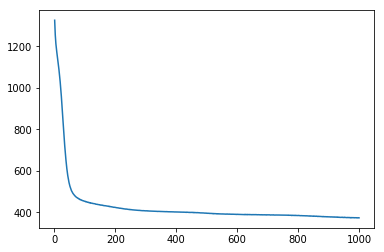

In [15]:
plt.plot(range(1, len(cost_log)+1), cost_log)
plt.show()

In [16]:
test_labels_names_dict = get_labels_names_dict(test_labels_names, num_of_examples)
domains_data_test, domains_label_test = get_domains_data(test_data, num_of_domains, test_labels_names_dict)
feed_dict_test = get_feed_dict(edn.placeholder, domains_data_test, num_of_domains)

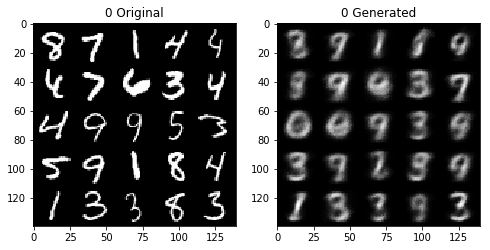

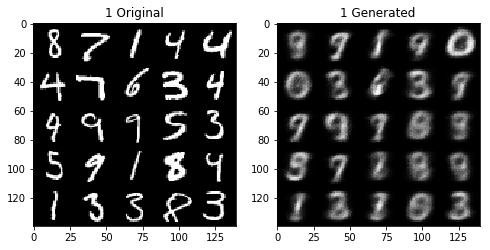

In [18]:
# Testing
# Encode and decode images from test set and visualize their reconstruction.
n = 5
examples = np.random.randint(num_of_examples, size=n*n)

for a_domain in range(num_of_domains):
    canvas_orig = np.empty((28 * n, 28 * n))
    canvas_recon = np.empty((28 * n, 28 * n))
    fig, all_plots = plt.subplots(1, 2, figsize=(8, 8))
    for i in range(n):
        # MNIST test set
        # Encode and decode the digit image
        g = edn.sess.run(edn.placeholder["prediction"][a_domain], feed_dict=feed_dict_test)
        
        # Display original images
        for j, example_i in zip(range(n), examples[i*n:i*n+n]):
            # Draw the generated digits
            canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = domains_data_test['domain_'+str(a_domain)][example_i].reshape([28, 28])
        # Display reconstructed images
        for j, example_i in zip(range(n), examples[i*n:i*n+n]):
            # Draw the generated digits
            canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[example_i].reshape([28, 28])

    all_plots[0].set_title(str(a_domain)+" Original")
    all_plots[0].imshow(canvas_orig, origin="upper", cmap="gray")

    all_plots[1].set_title(str(a_domain)+" Generated")
    all_plots[1].imshow(canvas_recon, origin="upper", cmap="gray")
    plt.show()